# SNN on ICUB Data with BioTAC

Here we implement autoencoder:

loss = loss_classification + loss_regression

In [123]:
import sys, os
CURRENT_TEST_DIR = os.getcwd()
sys.path.append(CURRENT_TEST_DIR + "/../../../slayerPytorch/src")

In [124]:
import slayerSNN as snn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
from joblib import Parallel, delayed
import torch
import copy
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from tas_utils import get_trainValLoader, get_testLoader

np.random.seed(1)
torch.manual_seed(1)

### upload data

In [125]:
data_dir = '../../new_data_folder/'
logDir = 'models_and_stats/'
kfold_number = 0

model_name = 'semisupervised_icub_' + str(kfold_number)
screen_fr = 20

save_dir = logDir + model_name + '.pt'

train_loader, val_loader, train_dataset, val_dataset = get_trainValLoader(data_dir, k=0)
test_loader, test_dataset = get_testLoader(data_dir)

### define spike neuron

In [126]:
params = {
    "neuron": {
        "type": "SRMALPHA",
        "theta": 5, # 10
        "tauSr": 10.0,
        "tauRef": 2.0,
        "scaleRef": 2,
        "tauRho": 1,
        "scaleRho": 1,
    },
    "simulation": {"Ts": 1.0, "tSample": 75, "nSample": 1},
    "training": {
        "error": {
            "type": "NumSpikes",  # "NumSpikes" or "ProbSpikes"
            "probSlidingWin": 20,  # only valid for ProbSpikes
            "tgtSpikeRegion": {  # valid for NumSpikes and ProbSpikes
                "start": 0,
                "stop": 75,
            },
            "tgtSpikeCount": {True: 60, False: 10},
        }
    },
}

params2 = {
    "neuron": {
        "type": "SRMALPHA",
        "theta": 5, # 10
        "tauSr": 10.0,
        "tauRef": 2.0,
        "scaleRef": 2,
        "tauRho": 1,
        "scaleRho": 1,
    },
    "simulation": {"Ts": 1.0, "tSample": 75, "nSample": 1},
    "training": {
        "error": {
            "type": "SpikeTime",  # "NumSpikes" or "ProbSpikes"
            "probSlidingWin": 20,  # only valid for ProbSpikes
            "tgtSpikeRegion": {  # valid for NumSpikes and ProbSpikes
                "start": 0,
                "stop": 75,
            },
            "tgtSpikeCount": {True: 60, False: 10},
        }
    },
}

In [127]:
def freeze_model(model):
    model.eval()
    for params in model.parameters():
        params.requires_grad = False

In [128]:
class SlayerMLP(torch.nn.Module):
    def __init__(self, params, input_size, hidden_size1, hidden_size2, output_size):
        super(SlayerMLP, self).__init__()
        self.output_size = output_size
        self.slayer = snn.layer(params["neuron"], params["simulation"])
        self.fc1 = self.slayer.dense(input_size, hidden_size1)
        self.fc2 = self.slayer.dense(hidden_size1, hidden_size2)
        self.fc3 = self.slayer.dense(hidden_size2, output_size)
        
        self.fc_decoder1 = self.slayer.dense(hidden_size2, 30)
        self.fc_decoder2 = self.slayer.dense(30, input_size)

    def get_spike(self, inp):
        return self.slayer.spike(inp)
    
    def classifier(self, inp):
        return self.slayer.spike(self.slayer.psp(self.fc3(inp)))
    
    def forward(self, spike_input):
        spike_1 = self.slayer.spike(self.slayer.psp(self.fc1(spike_input)))
        spike_2 = self.slayer.spike(self.slayer.psp(self.fc2(spike_1)))
        spike_output = self.slayer.spike(self.slayer.psp(self.fc3(spike_2)))
        
        spike_hat1 = self.slayer.spike(self.slayer.psp(self.fc_decoder1(spike_2)))
        spike_hat2 = self.slayer.spike(self.slayer.psp(self.fc_decoder2(spike_hat1)))
        
        return spike_output, spike_hat2, spike_2, spike_hat1

In [129]:
class TransferLearn(torch.nn.Module):
    def __init__(self, params, input_size, hidden_size1, hidden_size2,hidden_size3, output_size):
        super(TransferLearn, self).__init__()
        self.output_size = output_size
        self.slayer = snn.layer(params["neuron"], params["simulation"])
        self.fc1 = self.slayer.dense(input_size, hidden_size1)
        self.fc2 = self.slayer.dense(hidden_size1, hidden_size2)
        self.fc3 = self.slayer.dense(hidden_size2, hidden_size3)
        
#         self.classifier = SlayerMLP(params, 19, 50, 50, 20).fc3
#         params = self.classifier.parameters()
#         for param in params:
#             param.require_grad = False
        

    def get_spike(self, inp):
        return self.slayer.spike(inp)
    
    def forward(self, spike_input):
        spike_1 = self.slayer.spike(self.slayer.psp(self.fc1(spike_input)))
        spike_2 = self.slayer.spike(self.slayer.psp(self.fc2(spike_1)))
        spike_3 = self.slayer.spike(self.slayer.psp(self.fc3(spike_2)))
#         spike_output = self.slayer.spike(self.slayer.psp(self.classifier(spike_3)))
        
        return spike_3

In [133]:
device = torch.device("cuda:2")

# pretrained biotac model
net_rep = SlayerMLP(params, 19, 50, 50, 20).to(device)
net_rep.load_state_dict(torch.load(logDir + 'semisupervised_bio_' + str(kfold_number) + '.pt'))
net_rep.eval()
freeze_model(net_rep)

# trainable icub model
net = TransferLearn(params, 60, 50, 50, 50, 20).to(device)

In [134]:
error = snn.loss(params).to(device)
error2 = snn.loss(params2).to(device)
optimizer = torch.optim.RMSprop(net.parameters(), lr=0.001, weight_decay=0.5)

In [135]:
train_total_losses=[]
train_class_losses=[]
train_regres_losses=[]

val_total_losses=[]
val_class_losses=[]
val_regres_losses=[]

test_total_losses=[]
test_class_losses=[]
test_regres_losses=[]

train_accs = []
test_accs = []
val_accs = []


alpha = 0 #0.001
beta = 1

max_val_acc = 0

for epoch in range(30001):
    net.train()
    correct = 0
    loss_train = 0
    loss_class = 0
    loss_reg = 0
    for i, (tact_icub, tact_bio,  target, label) in enumerate(train_loader):
        
        tact_icub = tact_icub.to(device)
        tact_bio = tact_bio.to(device)
        tact_bio = tact_bio[...,::2]
        target = target.to(device)
        tact_icub = net.get_spike(tact_icub)
        tact_bio = net.get_spike(tact_bio)
        
     
        _, _, rep_out_bio, _ = net_rep.forward(tact_bio)
            
        rep_out_icub = net.forward(tact_icub)
        
        output = net_rep.classifier(rep_out_icub) # classifier
        
        #print(rep_out_bio.shape, rep_out_icub.shape)
        
        correct += torch.sum(snn.predict.getClass(output) == label).data.item()
        loss_class = error.numSpikes(output, target)
        
        loss_reg = error2.spikeTime(rep_out_bio, rep_out_icub)
        
        loss = alpha*loss_class + beta*loss_reg
        
        loss_train += loss.item()
        loss_class += alpha*loss_class.item()
        loss_reg += beta*loss_reg.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
                
    if epoch%screen_fr == 0:
        print('Epoch: ', epoch, ' --------------------------')
        print('Train loss (all, class, reg):', 
              loss_train/len(train_dataset),
              loss_class.item()/len(train_dataset),
              loss_reg.item()/len(train_dataset))
        print('Train accuracy:', correct/len(train_dataset))
    train_accs.append(correct/len(train_dataset))
    train_total_losses.append(loss_train/len(train_dataset))
    train_class_losses.append(loss_class.item()/len(train_dataset))
    train_regres_losses.append(loss_reg.item()/len(train_dataset))
    
    net.eval()
    correct = 0
    loss_val = 0
    loss_class = 0
    loss_reg = 0
    with torch.no_grad():
        for i, (tact_icub, tact_bio,  target, label) in enumerate(val_loader):

            tact_icub = tact_icub.to(device)
            tact_bio = tact_bio.to(device)
            tact_bio = tact_bio[...,::2]
            target = target.to(device)
            tact_icub = net.get_spike(tact_icub)
            tact_bio = net.get_spike(tact_bio)

            _, _, rep_out_bio, _ = net_rep.forward(tact_bio)

            rep_out_icub = net.forward(tact_icub)
            
            output = net_rep.classifier(rep_out_icub) # classifier

            #print(rep_out_bio.shape, rep_out_icub.shape)
        
            correct += torch.sum(snn.predict.getClass(output) == label).data.item()
            loss_class = error.numSpikes(output, target)

            loss_reg = error2.spikeTime(rep_out_bio, rep_out_icub)

            loss = alpha*loss_class + beta*loss_reg

            loss_val += loss.item()
            loss_class += alpha*loss_class.item()
            loss_reg += beta*loss_reg.item()
            
    if epoch%screen_fr == 0:
        print('Val loss (all, class, reg):', 
              loss_val/len(val_dataset),
              loss_class.item()/len(val_dataset),
              loss_reg.item()/len(val_dataset))
        print('Val accuracy:', correct/len(val_dataset))
    val_accs.append(correct/len(val_dataset))
    val_total_losses.append(loss_val/len(val_dataset))
    val_class_losses.append(loss_class.item()/len(val_dataset))
    val_regres_losses.append(loss_reg.item()/len(val_dataset))
    
#     if correct/len(val_dataset) >= max_val_acc:
#         print('Saving model at ', epoch, ' epoch')
#         max_val_acc = correct/len(val_dataset)
#         torch.save(net.state_dict(), save_dir)

Epoch:  0  --------------------------
Train loss (all, class, reg): 90967.60604166667 0.44558893839518227 2151.75875
Train accuracy: 0.06333333333333334
Val loss (all, class, reg): 67754.69421875 1.338033447265625 5620.59
Val accuracy: 0.06
Epoch:  20  --------------------------
Train loss (all, class, reg): 32630.741979166665 0.3504778035481771 603.1942708333333
Train accuracy: 0.21
Val loss (all, class, reg): 34683.450078125 1.0670999908447265 2714.695625
Val accuracy: 0.175
Epoch:  40  --------------------------
Train loss (all, class, reg): 24834.2962890625 0.25912221272786456 647.323125
Train accuracy: 0.33166666666666667
Val loss (all, class, reg): 27803.100234375 0.976199951171875 1637.1215625
Val accuracy: 0.275
Epoch:  60  --------------------------
Train loss (all, class, reg): 20917.2820703125 0.2226666514078776 902.3328125
Train accuracy: 0.45
Val loss (all, class, reg): 24528.37046875 0.8144332885742187 1862.87796875
Val accuracy: 0.39
Epoch:  80  -------------------------

Epoch:  660  --------------------------
Train loss (all, class, reg): 10249.25416015625 0.14316668192545573 207.67404947916665
Train accuracy: 0.8533333333333334
Val loss (all, class, reg): 18552.2391015625 0.39666664123535156 1444.2475
Val accuracy: 0.69
Epoch:  680  --------------------------
Train loss (all, class, reg): 10085.418450520834 0.10697778065999348 248.8403125
Train accuracy: 0.8483333333333334
Val loss (all, class, reg): 18644.757890625 0.5326333236694336 2400.9521875
Val accuracy: 0.7
Epoch:  700  --------------------------
Train loss (all, class, reg): 10075.085625 0.10833333333333334 238.1584375
Train accuracy: 0.8533333333333334
Val loss (all, class, reg): 18710.6049609375 0.2630666732788086 1189.91203125
Val accuracy: 0.72
Epoch:  720  --------------------------
Train loss (all, class, reg): 10000.54095703125 0.07142222086588541 240.1753125
Train accuracy: 0.8566666666666667
Val loss (all, class, reg): 19169.8481640625 0.32970001220703127 1212.57109375
Val accuracy:

Epoch:  1320  --------------------------
Train loss (all, class, reg): 8638.755787760416 0.09583333333333334 144.25578125
Train accuracy: 0.8916666666666667
Val loss (all, class, reg): 19045.68953125 0.4141999816894531 1313.75703125
Val accuracy: 0.72
Epoch:  1340  --------------------------
Train loss (all, class, reg): 8537.937747395834 0.11422220865885417 285.75067708333336
Train accuracy: 0.8866666666666667
Val loss (all, class, reg): 19066.8815625 0.3731666564941406 1465.4971875
Val accuracy: 0.715
Epoch:  1360  --------------------------
Train loss (all, class, reg): 8557.641067708333 0.11338888804117839 298.27872395833333
Train accuracy: 0.88
Val loss (all, class, reg): 18901.1615234375 0.26733333587646485 1217.66109375
Val accuracy: 0.705
Epoch:  1380  --------------------------
Train loss (all, class, reg): 8506.081588541667 0.11001111348470052 192.87967447916665
Train accuracy: 0.885
Val loss (all, class, reg): 19003.1498046875 0.4761333465576172 1555.6671875
Val accuracy: 0.

Epoch:  1980  --------------------------
Train loss (all, class, reg): 7962.781868489584 0.12304444630940756 186.955078125
Train accuracy: 0.9033333333333333
Val loss (all, class, reg): 18966.6915234375 0.22903335571289063 1441.879375
Val accuracy: 0.745
Epoch:  2000  --------------------------
Train loss (all, class, reg): 7910.846246744792 0.10035555521647135 127.484296875
Train accuracy: 0.9
Val loss (all, class, reg): 19307.80123046875 0.2549333190917969 1051.165234375
Val accuracy: 0.705
Epoch:  2020  --------------------------
Train loss (all, class, reg): 7872.47365234375 0.0667555554707845 225.26984375
Train accuracy: 0.9083333333333333
Val loss (all, class, reg): 19021.5413671875 0.24520000457763672 1392.3428125
Val accuracy: 0.72
Epoch:  2040  --------------------------
Train loss (all, class, reg): 7918.270299479167 0.0845888900756836 214.6560546875
Train accuracy: 0.91
Val loss (all, class, reg): 18999.001328125 0.3935666275024414 1086.130703125
Val accuracy: 0.705
Epoch:  

Epoch:  2640  --------------------------
Train loss (all, class, reg): 7454.568610026042 0.09482222239176433 220.93744791666666
Train accuracy: 0.91
Val loss (all, class, reg): 19075.7790625 0.36333335876464845 1149.256171875
Val accuracy: 0.715
Epoch:  2660  --------------------------
Train loss (all, class, reg): 7449.0546484375 0.08012222290039063 151.06174479166665
Train accuracy: 0.9116666666666666
Val loss (all, class, reg): 19186.35765625 0.508466682434082 3124.5553125
Val accuracy: 0.72
Epoch:  2680  --------------------------
Train loss (all, class, reg): 7490.785751953125 0.04348888715108236 125.76662760416667
Train accuracy: 0.9083333333333333
Val loss (all, class, reg): 19461.290234375 0.1419333267211914 1568.26328125
Val accuracy: 0.72
Epoch:  2700  --------------------------
Train loss (all, class, reg): 7441.405305989583 0.08507777531941732 121.3623828125
Train accuracy: 0.915
Val loss (all, class, reg): 19413.323359375 0.4039666748046875 2326.8325
Val accuracy: 0.72
Epo

Epoch:  3300  --------------------------
Train loss (all, class, reg): 7212.822180989583 0.056599998474121095 99.23580078125
Train accuracy: 0.9166666666666666
Val loss (all, class, reg): 19203.9763671875 0.22743331909179687 901.6875
Val accuracy: 0.735
Epoch:  3320  --------------------------
Train loss (all, class, reg): 7184.425442708333 0.0751888910929362 150.8009375
Train accuracy: 0.9166666666666666
Val loss (all, class, reg): 19155.183671875 0.3066666412353516 1352.1115625
Val accuracy: 0.74
Epoch:  3340  --------------------------
Train loss (all, class, reg): 7193.6280696614585 0.06711111068725586 184.50015625
Train accuracy: 0.9133333333333333
Val loss (all, class, reg): 19244.937109375 0.3504999923706055 1698.18625
Val accuracy: 0.715
Epoch:  3360  --------------------------
Train loss (all, class, reg): 7151.550074869791 0.06721110661824545 161.7690625
Train accuracy: 0.9133333333333333
Val loss (all, class, reg): 19329.363203125 0.3711000061035156 1164.17796875
Val accurac

Epoch:  3960  --------------------------
Train loss (all, class, reg): 6956.766689453125 0.07327777862548829 211.66415364583332
Train accuracy: 0.9233333333333333
Val loss (all, class, reg): 19445.862421875 0.18329999923706056 660.7109375
Val accuracy: 0.74
Epoch:  3980  --------------------------
Train loss (all, class, reg): 6917.0659798177085 0.038711109161376954 135.584921875
Train accuracy: 0.915
Val loss (all, class, reg): 19211.396640625 0.32800003051757814 1530.21625
Val accuracy: 0.74
Epoch:  4000  --------------------------
Train loss (all, class, reg): 6941.978160807292 0.07931111017862956 184.27078125
Train accuracy: 0.9183333333333333
Val loss (all, class, reg): 19549.8521484375 0.2228666687011719 1125.48875
Val accuracy: 0.73
Epoch:  4020  --------------------------
Train loss (all, class, reg): 6936.576266276042 0.0845111083984375 239.599453125
Train accuracy: 0.9233333333333333
Val loss (all, class, reg): 19191.5466796875 0.16079999923706054 1040.24359375
Val accuracy: 

Epoch:  4620  --------------------------
Train loss (all, class, reg): 6758.875026041666 0.08535555521647135 167.36998697916667
Train accuracy: 0.9266666666666666
Val loss (all, class, reg): 19909.8639453125 0.2798666572570801 1464.1959375
Val accuracy: 0.74
Epoch:  4640  --------------------------
Train loss (all, class, reg): 6728.919700520833 0.06315555572509765 129.7076171875
Train accuracy: 0.9266666666666666
Val loss (all, class, reg): 19708.571171875 0.19630001068115235 1063.025625
Val accuracy: 0.745
Epoch:  4660  --------------------------
Train loss (all, class, reg): 6694.931708984375 0.09162222544352214 424.85859375
Train accuracy: 0.92
Val loss (all, class, reg): 20265.795234375 0.32133331298828127 1382.8659375
Val accuracy: 0.735
Epoch:  4680  --------------------------
Train loss (all, class, reg): 6709.734016927084 0.06302221934000651 199.488046875
Train accuracy: 0.9266666666666666
Val loss (all, class, reg): 19993.8265625 0.19483333587646484 1555.99484375
Val accuracy

Epoch:  5280  --------------------------
Train loss (all, class, reg): 6599.553255208333 0.07360000610351562 84.66380208333334
Train accuracy: 0.92
Val loss (all, class, reg): 20085.9737109375 0.30073333740234376 2146.224375
Val accuracy: 0.73
Epoch:  5300  --------------------------
Train loss (all, class, reg): 6528.703017578125 0.044877780278523766 118.53247395833333
Train accuracy: 0.9266666666666666
Val loss (all, class, reg): 19772.29484375 0.2681666564941406 1681.31046875
Val accuracy: 0.745
Epoch:  5320  --------------------------
Train loss (all, class, reg): 6553.88814453125 0.0584000015258789 87.92770833333333
Train accuracy: 0.925
Val loss (all, class, reg): 19881.87765625 0.2778666687011719 1731.39390625
Val accuracy: 0.73
Epoch:  5340  --------------------------
Train loss (all, class, reg): 6508.888512369792 0.07897778193155924 168.86611979166668
Train accuracy: 0.9266666666666666
Val loss (all, class, reg): 20047.7050390625 0.2686666679382324 1566.18265625
Val accuracy:

Epoch:  5940  --------------------------
Train loss (all, class, reg): 6432.354264322917 0.054033330281575524 114.273671875
Train accuracy: 0.92
Val loss (all, class, reg): 20549.3682421875 0.23459999084472657 996.0346875
Val accuracy: 0.715
Epoch:  5960  --------------------------
Train loss (all, class, reg): 6480.303636067708 0.05748888651529948 133.28848958333333
Train accuracy: 0.92
Val loss (all, class, reg): 20083.1724609375 0.40443336486816406 1802.99265625
Val accuracy: 0.705
Epoch:  5980  --------------------------
Train loss (all, class, reg): 6528.811031901042 0.08694444020589193 237.40807291666667
Train accuracy: 0.9283333333333333
Val loss (all, class, reg): 20397.1956640625 0.30599998474121093 1702.94390625
Val accuracy: 0.71
Epoch:  6000  --------------------------
Train loss (all, class, reg): 6417.187027994792 0.050788892110188805 95.89213541666666
Train accuracy: 0.9216666666666666
Val loss (all, class, reg): 19938.5971484375 0.39626667022705075 1426.43484375
Val acc

Epoch:  6600  --------------------------
Train loss (all, class, reg): 6407.854759114583 0.0557888921101888 171.27940104166666
Train accuracy: 0.9266666666666666
Val loss (all, class, reg): 20475.985703125 0.31329999923706053 947.712578125
Val accuracy: 0.715
Epoch:  6620  --------------------------
Train loss (all, class, reg): 6407.90169921875 0.053255558013916016 120.81147135416667
Train accuracy: 0.92
Val loss (all, class, reg): 20311.577265625 0.47073333740234374 1616.37546875
Val accuracy: 0.705
Epoch:  6640  --------------------------
Train loss (all, class, reg): 6381.3724609375 0.03626666704813639 119.20184895833333
Train accuracy: 0.92
Val loss (all, class, reg): 20294.274609375 0.26360000610351564 1364.93921875
Val accuracy: 0.69
Epoch:  6660  --------------------------
Train loss (all, class, reg): 6368.689410807292 0.044966665903727214 406.3637239583333
Train accuracy: 0.9333333333333333
Val loss (all, class, reg): 20357.8443359375 0.205 2067.07984375
Val accuracy: 0.72
Ep

Epoch:  7260  --------------------------
Train loss (all, class, reg): 6203.779231770834 0.05651111602783203 98.61336588541667
Train accuracy: 0.9266666666666666
Val loss (all, class, reg): 20364.9186328125 0.36723331451416014 1429.051875
Val accuracy: 0.705
Epoch:  7280  --------------------------
Train loss (all, class, reg): 6215.0513704427085 0.02504444440205892 148.45147135416667
Train accuracy: 0.9283333333333333
Val loss (all, class, reg): 20478.4233203125 0.2156333351135254 1225.383125
Val accuracy: 0.725
Epoch:  7300  --------------------------
Train loss (all, class, reg): 6225.279964192709 0.03213333447774251 84.37337239583333
Train accuracy: 0.9283333333333333
Val loss (all, class, reg): 20306.938984375 0.3202333450317383 1651.2584375
Val accuracy: 0.715
Epoch:  7320  --------------------------
Train loss (all, class, reg): 6221.111988932292 0.059800001780192055 161.21692708333333
Train accuracy: 0.9216666666666666
Val loss (all, class, reg): 20415.5865234375 0.316700000762

Epoch:  7920  --------------------------
Train loss (all, class, reg): 6192.499065755208 0.051022218068440754 136.24951822916665
Train accuracy: 0.935
Val loss (all, class, reg): 20747.524609375 0.22453332901000977 1582.38484375
Val accuracy: 0.71
Epoch:  7940  --------------------------
Train loss (all, class, reg): 6161.658902994792 0.039177780151367185 78.47130208333333
Train accuracy: 0.9266666666666666
Val loss (all, class, reg): 20677.47888671875 0.3190333366394043 1823.03625
Val accuracy: 0.705
Epoch:  7960  --------------------------
Train loss (all, class, reg): 6156.752027994792 0.08147777557373047 502.03208333333333
Train accuracy: 0.935
Val loss (all, class, reg): 20932.156015625 0.5524333190917968 2490.5440625
Val accuracy: 0.705
Epoch:  7980  --------------------------
Train loss (all, class, reg): 6123.436402994792 0.033777780532836914 76.95270833333333
Train accuracy: 0.9383333333333334
Val loss (all, class, reg): 20735.417578125 0.21673334121704102 1045.09859375
Val ac

Epoch:  8580  --------------------------
Train loss (all, class, reg): 6100.98736328125 0.036177778244018556 94.27921875
Train accuracy: 0.9316666666666666
Val loss (all, class, reg): 21136.675 0.2151333236694336 1417.2134375
Val accuracy: 0.705
Epoch:  8600  --------------------------
Train loss (all, class, reg): 6071.4337337239585 0.061855557759602865 367.51057291666666
Train accuracy: 0.93
Val loss (all, class, reg): 20732.6921484375 0.2589999771118164 1060.398984375
Val accuracy: 0.7
Epoch:  8620  --------------------------
Train loss (all, class, reg): 6123.319583333333 0.07757778167724609 135.52122395833334
Train accuracy: 0.935
Val loss (all, class, reg): 20831.130078125 0.2835333251953125 1833.8453125
Val accuracy: 0.71
Epoch:  8640  --------------------------
Train loss (all, class, reg): 6044.527379557292 0.03146666526794434 76.38408854166667
Train accuracy: 0.9316666666666666
Val loss (all, class, reg): 20815.37828125 0.499466667175293 2698.27125
Val accuracy: 0.71
Epoch:  

Epoch:  9240  --------------------------
Train loss (all, class, reg): 6036.350406901041 0.04682222366333008 130.57794270833332
Train accuracy: 0.925
Val loss (all, class, reg): 21106.06791015625 0.3535000228881836 1360.07234375
Val accuracy: 0.715
Epoch:  9260  --------------------------
Train loss (all, class, reg): 6040.737037760417 0.042477779388427735 107.94993489583334
Train accuracy: 0.925
Val loss (all, class, reg): 20943.6097265625 0.20580001831054687 1496.435
Val accuracy: 0.69
Epoch:  9280  --------------------------
Train loss (all, class, reg): 6084.209563802084 0.03183333079020182 86.20589192708333
Train accuracy: 0.9366666666666666
Val loss (all, class, reg): 21029.8459765625 0.46623332977294923 1587.2871875
Val accuracy: 0.69
Epoch:  9300  --------------------------
Train loss (all, class, reg): 5978.668492838542 0.07188888549804688 399.9484375
Train accuracy: 0.9333333333333333
Val loss (all, class, reg): 21123.222578125 0.30100000381469727 2013.6078125
Val accuracy: 0

Epoch:  9900  --------------------------
Train loss (all, class, reg): 5929.025201822917 0.09299999872843424 443.0221875
Train accuracy: 0.935
Val loss (all, class, reg): 20933.773359375 0.34996665954589845 1339.200625
Val accuracy: 0.73
Epoch:  9920  --------------------------
Train loss (all, class, reg): 5942.738564453125 0.030833333333333334 93.50213541666666
Train accuracy: 0.9333333333333333
Val loss (all, class, reg): 21050.74484375 0.41756668090820315 1913.3696875
Val accuracy: 0.725
Epoch:  9940  --------------------------
Train loss (all, class, reg): 5942.972005208333 0.03201111157735189 86.988671875
Train accuracy: 0.9333333333333333
Val loss (all, class, reg): 20862.04640625 0.2398666572570801 1575.4146875
Val accuracy: 0.725
Epoch:  9960  --------------------------
Train loss (all, class, reg): 5957.472685546875 0.07725555419921876 89.41307291666666
Train accuracy: 0.9316666666666666
Val loss (all, class, reg): 20916.9238671875 0.3277000045776367 1439.45171875
Val accurac

Epoch:  10560  --------------------------
Train loss (all, class, reg): 5918.74015625 0.07381111145019531 304.38104166666665
Train accuracy: 0.94
Val loss (all, class, reg): 20766.986015625 0.28389999389648435 1148.8984375
Val accuracy: 0.735
Epoch:  10580  --------------------------
Train loss (all, class, reg): 5875.860667317708 0.06123333613077799 124.99524739583333
Train accuracy: 0.935
Val loss (all, class, reg): 20598.2797265625 0.26476665496826174 1113.78875
Val accuracy: 0.745
Epoch:  10600  --------------------------
Train loss (all, class, reg): 5849.9301171875 0.046433334350585935 71.26046875
Train accuracy: 0.925
Val loss (all, class, reg): 20814.546875 0.288700008392334 2234.36421875
Val accuracy: 0.735
Epoch:  10620  --------------------------
Train loss (all, class, reg): 5872.792705078125 0.10695555369059245 307.4599479166667
Train accuracy: 0.9283333333333333
Val loss (all, class, reg): 20811.8276953125 0.22029998779296875 1693.068125
Val accuracy: 0.74
Epoch:  10640  

Epoch:  11220  --------------------------
Train loss (all, class, reg): 5863.1143359375 0.08527777989705404 337.6152083333333
Train accuracy: 0.9316666666666666
Val loss (all, class, reg): 20675.2394921875 0.33856666564941407 1716.01171875
Val accuracy: 0.705
Epoch:  11240  --------------------------
Train loss (all, class, reg): 5881.612841796875 0.05827777862548828 149.26805989583335
Train accuracy: 0.935
Val loss (all, class, reg): 20560.3033984375 0.3302666473388672 1411.390625
Val accuracy: 0.745
Epoch:  11260  --------------------------
Train loss (all, class, reg): 5860.071627604167 0.06463333129882813 123.534609375
Train accuracy: 0.9283333333333333
Val loss (all, class, reg): 20572.6965625 0.42529998779296874 1364.1334375
Val accuracy: 0.725
Epoch:  11280  --------------------------
Train loss (all, class, reg): 5844.627942708334 0.06208889007568359 152.180078125
Train accuracy: 0.9366666666666666
Val loss (all, class, reg): 20495.9835546875 0.30476667404174806 1213.076875
Val

Epoch:  11880  --------------------------
Train loss (all, class, reg): 5726.512037760417 0.07646666208902995 118.07559895833333
Train accuracy: 0.93
Val loss (all, class, reg): 20932.4310546875 0.13243333816528322 1842.9175
Val accuracy: 0.72
Epoch:  11900  --------------------------
Train loss (all, class, reg): 5783.309241536458 0.05978889465332031 78.66791666666667
Train accuracy: 0.925
Val loss (all, class, reg): 20876.5942578125 0.4901000213623047 2790.980625
Val accuracy: 0.73
Epoch:  11920  --------------------------
Train loss (all, class, reg): 5767.177513020833 0.06344444274902344 87.50375651041666
Train accuracy: 0.93
Val loss (all, class, reg): 20784.7866015625 0.4146333312988281 2214.5171875
Val accuracy: 0.745
Epoch:  11940  --------------------------
Train loss (all, class, reg): 5868.257434895833 0.05622222264607747 162.83026041666668
Train accuracy: 0.9266666666666666
Val loss (all, class, reg): 20904.0323046875 0.44366668701171874 2322.3175
Val accuracy: 0.735
Epoch:

Epoch:  12540  --------------------------
Train loss (all, class, reg): 5742.454029947917 0.06376667022705078 110.28677083333334
Train accuracy: 0.9233333333333333
Val loss (all, class, reg): 20880.1037890625 0.3722999954223633 1690.2375
Val accuracy: 0.74
Epoch:  12560  --------------------------
Train loss (all, class, reg): 5778.650670572917 0.03234444300333659 82.13281901041667
Train accuracy: 0.9333333333333333
Val loss (all, class, reg): 20777.0862109375 0.37986663818359373 2661.341875
Val accuracy: 0.755
Epoch:  12580  --------------------------
Train loss (all, class, reg): 5775.982587890625 0.07217777887980144 95.30453776041666
Train accuracy: 0.935
Val loss (all, class, reg): 20524.1794140625 0.27046665191650393 1561.969375
Val accuracy: 0.755
Epoch:  12600  --------------------------
Train loss (all, class, reg): 5780.8011686197915 0.060655555725097655 200.84213541666668
Train accuracy: 0.93
Val loss (all, class, reg): 20764.1930078125 0.31356666564941404 1599.5053125
Val ac

Epoch:  13200  --------------------------
Train loss (all, class, reg): 5680.527529296875 0.059377772013346354 84.95159505208333
Train accuracy: 0.9266666666666666
Val loss (all, class, reg): 21046.17921875 0.23733333587646485 1060.45984375
Val accuracy: 0.735
Epoch:  13220  --------------------------
Train loss (all, class, reg): 5726.955419921875 0.05594444274902344 170.53888020833332
Train accuracy: 0.9233333333333333
Val loss (all, class, reg): 21090.680234375 0.26743331909179685 1468.706875
Val accuracy: 0.715
Epoch:  13240  --------------------------
Train loss (all, class, reg): 5706.170364583333 0.06064444224039713 133.32796875
Train accuracy: 0.9266666666666666
Val loss (all, class, reg): 20860.8651953125 0.47686668395996096 2423.5203125
Val accuracy: 0.74
Epoch:  13260  --------------------------
Train loss (all, class, reg): 5775.378502604167 0.06478888829549154 151.26415364583335
Train accuracy: 0.9316666666666666
Val loss (all, class, reg): 20881.0348046875 0.2896999931335

Epoch:  13860  --------------------------
Train loss (all, class, reg): 5692.342220052084 0.05628888448079427 74.97729166666667
Train accuracy: 0.935
Val loss (all, class, reg): 20966.344140625 0.24086666107177734 831.033359375
Val accuracy: 0.74
Epoch:  13880  --------------------------
Train loss (all, class, reg): 5695.972652994792 0.07245555877685547 460.945625
Train accuracy: 0.93
Val loss (all, class, reg): 21289.044296875 0.3290000152587891 1838.450625
Val accuracy: 0.72
Epoch:  13900  --------------------------
Train loss (all, class, reg): 5617.128831380208 0.09960000356038412 295.6245833333333
Train accuracy: 0.93
Val loss (all, class, reg): 21026.3011328125 0.43866668701171874 2367.898125
Val accuracy: 0.74
Epoch:  13920  --------------------------
Train loss (all, class, reg): 5648.779075520833 0.039866666793823245 197.52294270833335
Train accuracy: 0.9233333333333333
Val loss (all, class, reg): 20783.8719140625 0.28396665573120117 1100.7453125
Val accuracy: 0.745
Epoch:  1

Epoch:  14520  --------------------------
Train loss (all, class, reg): 5628.992623697916 0.13621111551920573 417.26697916666666
Train accuracy: 0.9283333333333333
Val loss (all, class, reg): 21070.3405078125 0.24206666946411132 936.439921875
Val accuracy: 0.765
Epoch:  14540  --------------------------
Train loss (all, class, reg): 5690.688287760417 0.08998888651529947 246.33049479166667
Train accuracy: 0.9216666666666666
Val loss (all, class, reg): 20871.1468359375 0.3224333190917969 1304.086171875
Val accuracy: 0.73
Epoch:  14560  --------------------------
Train loss (all, class, reg): 5626.870647786458 0.07575555801391602 135.41140625
Train accuracy: 0.9283333333333333
Val loss (all, class, reg): 21165.538203125 0.4709333038330078 2113.62859375
Val accuracy: 0.74
Epoch:  14580  --------------------------
Train loss (all, class, reg): 5663.854485677083 0.05176666259765625 108.14809244791667
Train accuracy: 0.9333333333333333
Val loss (all, class, reg): 21118.9552734375 0.2611666488

Epoch:  15180  --------------------------
Train loss (all, class, reg): 5640.021435546875 0.05934444427490235 297.68505208333335
Train accuracy: 0.93
Val loss (all, class, reg): 21220.1483984375 0.38106666564941405 2485.8409375
Val accuracy: 0.755
Epoch:  15200  --------------------------
Train loss (all, class, reg): 5613.155139973958 0.04593333562215169 80.05139322916666
Train accuracy: 0.9283333333333333
Val loss (all, class, reg): 21029.115390625 0.23153333663940429 1167.36484375
Val accuracy: 0.76
Epoch:  15220  --------------------------
Train loss (all, class, reg): 5613.731396484375 0.05385555267333984 163.02768229166668
Train accuracy: 0.93
Val loss (all, class, reg): 21136.5159375 0.46830001831054685 2009.1184375
Val accuracy: 0.75
Epoch:  15240  --------------------------
Train loss (all, class, reg): 5644.80224609375 0.09503332773844402 162.5831640625
Train accuracy: 0.93
Val loss (all, class, reg): 21163.005078125 0.3170333480834961 1136.081328125
Val accuracy: 0.755
Epoch

Epoch:  15840  --------------------------
Train loss (all, class, reg): 5563.933147786458 0.05826666514078776 112.1929296875
Train accuracy: 0.9333333333333333
Val loss (all, class, reg): 21190.300859375 0.49270000457763674 2182.600625
Val accuracy: 0.725
Epoch:  15860  --------------------------
Train loss (all, class, reg): 5600.597845052083 0.03396666844685872 73.80451822916666
Train accuracy: 0.93
Val loss (all, class, reg): 21185.9259765625 0.3445999908447266 2179.79140625
Val accuracy: 0.73
Epoch:  15880  --------------------------
Train loss (all, class, reg): 5621.329514973958 0.03505555470784505 94.63079427083333
Train accuracy: 0.9266666666666666
Val loss (all, class, reg): 21175.5361328125 0.363033332824707 2274.3296875
Val accuracy: 0.715
Epoch:  15900  --------------------------
Train loss (all, class, reg): 5630.903225911458 0.06862222035725911 78.249296875
Train accuracy: 0.925
Val loss (all, class, reg): 21197.3148828125 0.4740666580200195 2617.8440625
Val accuracy: 0.7

Epoch:  16500  --------------------------
Train loss (all, class, reg): 5572.6046875 0.06892222086588541 79.01962239583334
Train accuracy: 0.9283333333333333
Val loss (all, class, reg): 21456.301484375 0.38599998474121094 1400.79671875
Val accuracy: 0.745
Epoch:  16520  --------------------------
Train loss (all, class, reg): 5547.558102213542 0.060211105346679686 214.05998697916667
Train accuracy: 0.9266666666666666
Val loss (all, class, reg): 21493.260390625 0.240766658782959 1212.556875
Val accuracy: 0.735
Epoch:  16540  --------------------------
Train loss (all, class, reg): 5567.635221354167 0.05200000127156575 188.53977864583334
Train accuracy: 0.9283333333333333
Val loss (all, class, reg): 21399.80953125 0.3491333389282227 2229.4084375
Val accuracy: 0.72
Epoch:  16560  --------------------------
Train loss (all, class, reg): 5575.404733072916 0.042966667811075845 71.231015625
Train accuracy: 0.9216666666666666
Val loss (all, class, reg): 21305.189140625 0.22913333892822266 1857

Epoch:  17160  --------------------------
Train loss (all, class, reg): 5516.355139973958 0.028799997965494793 89.3826171875
Train accuracy: 0.9266666666666666
Val loss (all, class, reg): 21626.0419140625 0.3427000045776367 1748.92875
Val accuracy: 0.735
Epoch:  17180  --------------------------
Train loss (all, class, reg): 5459.749915364583 0.07728888829549153 518.61625
Train accuracy: 0.9266666666666666
Val loss (all, class, reg): 21828.549375 0.3579999923706055 1849.5753125
Val accuracy: 0.72
Epoch:  17200  --------------------------
Train loss (all, class, reg): 5519.912041015625 0.06856666564941406 201.99739583333334
Train accuracy: 0.93
Val loss (all, class, reg): 21259.6703125 0.38729999542236326 2297.42875
Val accuracy: 0.73
Epoch:  17220  --------------------------
Train loss (all, class, reg): 5559.649111328125 0.06777777353922526 85.20811197916667
Train accuracy: 0.9266666666666666
Val loss (all, class, reg): 20938.983046875 0.39413333892822267 2243.45734375
Val accuracy: 0

Epoch:  17820  --------------------------
Train loss (all, class, reg): 5544.752223307291 0.05116666793823242 79.420078125
Train accuracy: 0.925
Val loss (all, class, reg): 21345.2101171875 0.2980666732788086 2005.56890625
Val accuracy: 0.74
Epoch:  17840  --------------------------
Train loss (all, class, reg): 5588.367444661459 0.07385555267333985 244.40057291666668
Train accuracy: 0.925
Val loss (all, class, reg): 21232.973984375 0.2184666633605957 1805.8546875
Val accuracy: 0.74
Epoch:  17860  --------------------------
Train loss (all, class, reg): 5582.404293619792 0.060699996948242185 94.36426432291667
Train accuracy: 0.92
Val loss (all, class, reg): 21284.6725390625 0.37106666564941404 1714.64578125
Val accuracy: 0.72
Epoch:  17880  --------------------------
Train loss (all, class, reg): 5486.8767578125 0.06794443766276041 140.25015625
Train accuracy: 0.9266666666666666
Val loss (all, class, reg): 21339.845234375 0.47946666717529296 2735.014375
Val accuracy: 0.74
Epoch:  17900

Epoch:  18480  --------------------------
Train loss (all, class, reg): 5473.488128255209 0.03587778091430664 80.8218359375
Train accuracy: 0.93
Val loss (all, class, reg): 21571.3716015625 0.23779998779296874 2226.794375
Val accuracy: 0.725
Epoch:  18500  --------------------------
Train loss (all, class, reg): 5481.167470703125 0.05794445037841797 81.1634765625
Train accuracy: 0.9266666666666666
Val loss (all, class, reg): 21354.07234375 0.25336666107177735 928.60375
Val accuracy: 0.72
Epoch:  18520  --------------------------
Train loss (all, class, reg): 5478.662864583333 0.10944444020589193 180.06419270833334
Train accuracy: 0.9283333333333333
Val loss (all, class, reg): 21473.8049609375 0.32869998931884764 2419.02328125
Val accuracy: 0.75
Epoch:  18540  --------------------------
Train loss (all, class, reg): 5536.2001953125 0.05297777811686198 81.43052083333333
Train accuracy: 0.9283333333333333
Val loss (all, class, reg): 21440.537421875 0.22700000762939454 981.914375
Val accur

Epoch:  19140  --------------------------
Train loss (all, class, reg): 5444.287874348958 0.07765555063883464 203.51846354166668
Train accuracy: 0.925
Val loss (all, class, reg): 21493.8244921875 0.25753332138061524 1459.58
Val accuracy: 0.73
Epoch:  19160  --------------------------
Train loss (all, class, reg): 5432.7680045572915 0.05406666437784831 111.8365234375
Train accuracy: 0.925
Val loss (all, class, reg): 21559.155078125 0.240766658782959 1961.1478125
Val accuracy: 0.74
Epoch:  19180  --------------------------
Train loss (all, class, reg): 5419.083688151041 0.06531111399332683 125.79688802083334
Train accuracy: 0.9283333333333333
Val loss (all, class, reg): 21361.7809765625 0.17380001068115233 1135.151953125
Val accuracy: 0.73
Epoch:  19200  --------------------------
Train loss (all, class, reg): 5416.566614583333 0.045922222137451174 154.48805989583335
Train accuracy: 0.9283333333333333
Val loss (all, class, reg): 21389.706171875 0.2889999771118164 2155.95625
Val accuracy:

Epoch:  19800  --------------------------
Train loss (all, class, reg): 5427.388430989583 0.050588887532552085 128.6987109375
Train accuracy: 0.93
Val loss (all, class, reg): 21363.932109375 0.33733333587646486 1189.446875
Val accuracy: 0.73
Epoch:  19820  --------------------------
Train loss (all, class, reg): 5448.562705078125 0.07611110687255859 191.05166666666668
Train accuracy: 0.9333333333333333
Val loss (all, class, reg): 21182.8938671875 0.12023333549499511 1055.341484375
Val accuracy: 0.725
Epoch:  19840  --------------------------
Train loss (all, class, reg): 5460.598359375 0.06027777353922526 79.48717447916667
Train accuracy: 0.9283333333333333
Val loss (all, class, reg): 21269.5678515625 0.25559999465942385 1631.8509375
Val accuracy: 0.75
Epoch:  19860  --------------------------
Train loss (all, class, reg): 5441.9349609375 0.05841110865275065 84.108125
Train accuracy: 0.9233333333333333
Val loss (all, class, reg): 21357.81390625 0.40473331451416017 2207.16296875
Val acc

Epoch:  20460  --------------------------
Train loss (all, class, reg): 5416.679524739583 0.0714555549621582 158.11994791666666
Train accuracy: 0.9283333333333333
Val loss (all, class, reg): 21513.79015625 0.2393000030517578 1219.704375
Val accuracy: 0.74
Epoch:  20480  --------------------------
Train loss (all, class, reg): 5393.112350260417 0.06485556284586588 88.22920572916667
Train accuracy: 0.925
Val loss (all, class, reg): 21449.19765625 0.14836666107177734 809.40609375
Val accuracy: 0.735
Epoch:  20500  --------------------------
Train loss (all, class, reg): 5399.402451171875 0.06390000025431315 128.97973958333333
Train accuracy: 0.9283333333333333
Val loss (all, class, reg): 21457.9991015625 0.22803333282470703 1301.48234375
Val accuracy: 0.765
Epoch:  20520  --------------------------
Train loss (all, class, reg): 5428.0997102864585 0.030244442621866863 61.33350260416667
Train accuracy: 0.9166666666666666
Val loss (all, class, reg): 21392.13015625 0.45186668395996094 2600.08

Epoch:  21120  --------------------------
Train loss (all, class, reg): 5346.9053515625 0.0253000005086263 84.4629296875
Train accuracy: 0.9233333333333333
Val loss (all, class, reg): 21376.8150390625 0.5042333221435547 1894.80171875
Val accuracy: 0.705
Epoch:  21140  --------------------------
Train loss (all, class, reg): 5378.184261067709 0.04161110877990723 77.24820963541667
Train accuracy: 0.9266666666666666
Val loss (all, class, reg): 21319.347421875 0.3655666732788086 1547.89484375
Val accuracy: 0.735
Epoch:  21160  --------------------------
Train loss (all, class, reg): 5383.2839973958335 0.04517778396606445 216.18235677083334
Train accuracy: 0.9216666666666666
Val loss (all, class, reg): 21517.477734375 0.2234000015258789 1223.267421875
Val accuracy: 0.725
Epoch:  21180  --------------------------
Train loss (all, class, reg): 5376.915494791667 0.0603777821858724 103.8549609375
Train accuracy: 0.925
Val loss (all, class, reg): 21383.9725 0.17649999618530274 1594.25546875
Val 

Epoch:  21780  --------------------------
Train loss (all, class, reg): 5414.152220052083 0.04207777659098307 70.149453125
Train accuracy: 0.9233333333333333
Val loss (all, class, reg): 21889.5918359375 0.4063666534423828 2033.44953125
Val accuracy: 0.705
Epoch:  21800  --------------------------
Train loss (all, class, reg): 5429.950791015625 0.03878888765970866 78.58596354166667
Train accuracy: 0.925
Val loss (all, class, reg): 21898.4314453125 0.12856666564941407 1124.941484375
Val accuracy: 0.715
Epoch:  21820  --------------------------
Train loss (all, class, reg): 5395.2708528645835 0.043144445419311526 94.47962890625
Train accuracy: 0.925
Val loss (all, class, reg): 21976.6869140625 0.3799666595458984 2403.9940625
Val accuracy: 0.73
Epoch:  21840  --------------------------
Train loss (all, class, reg): 5388.062836914062 0.07591111501057943 104.55856770833333
Train accuracy: 0.92
Val loss (all, class, reg): 21978.4969140625 0.6357332992553711 2655.0234375
Val accuracy: 0.725
Ep

Epoch:  22440  --------------------------
Train loss (all, class, reg): 5352.456067708334 0.05308889071146647 103.53521484375
Train accuracy: 0.925
Val loss (all, class, reg): 22024.0309765625 0.34996665954589845 1445.3840625
Val accuracy: 0.74
Epoch:  22460  --------------------------
Train loss (all, class, reg): 5373.2337109375 0.061522216796875 137.61893229166665
Train accuracy: 0.9216666666666666
Val loss (all, class, reg): 22053.6220703125 0.31596664428710936 2030.48078125
Val accuracy: 0.71
Epoch:  22480  --------------------------
Train loss (all, class, reg): 5324.008120117188 0.03344444274902344 62.5171875
Train accuracy: 0.925
Val loss (all, class, reg): 21821.341015625 0.3501999664306641 975.91890625
Val accuracy: 0.725
Epoch:  22500  --------------------------
Train loss (all, class, reg): 5384.487503255208 0.05968888600667318 90.6478515625
Train accuracy: 0.9216666666666666
Val loss (all, class, reg): 21945.589140625 0.24869998931884765 1799.8809375
Val accuracy: 0.755
Ep

Epoch:  23100  --------------------------
Train loss (all, class, reg): 5329.26494140625 0.03973333676656087 93.37337890625
Train accuracy: 0.9283333333333333
Val loss (all, class, reg): 22196.432421875 0.30463333129882814 1316.77390625
Val accuracy: 0.735
Epoch:  23120  --------------------------
Train loss (all, class, reg): 5323.748235677083 0.043477776845296225 96.18951822916667
Train accuracy: 0.9266666666666666
Val loss (all, class, reg): 22095.6407421875 0.41816665649414064 2236.8090625
Val accuracy: 0.735
Epoch:  23140  --------------------------
Train loss (all, class, reg): 5314.203626302084 0.08258888880411784 152.2617578125
Train accuracy: 0.9216666666666666
Val loss (all, class, reg): 21961.32984375 0.16053333282470703 1537.93078125
Val accuracy: 0.725
Epoch:  23160  --------------------------
Train loss (all, class, reg): 5316.0780208333335 0.046511112848917645 71.53463541666666
Train accuracy: 0.9283333333333333
Val loss (all, class, reg): 21880.198359375 0.3201333236694

Epoch:  23760  --------------------------
Train loss (all, class, reg): 5279.580784505209 0.07782221476236979 210.76802083333334
Train accuracy: 0.9216666666666666
Val loss (all, class, reg): 22141.567109375 0.17190000534057617 1060.06390625
Val accuracy: 0.725
Epoch:  23780  --------------------------
Train loss (all, class, reg): 5297.310100911458 0.0364555549621582 64.64840494791666
Train accuracy: 0.9216666666666666
Val loss (all, class, reg): 22061.063515625 0.20206666946411134 2166.7065625
Val accuracy: 0.74
Epoch:  23800  --------------------------
Train loss (all, class, reg): 5336.515426432292 0.06799999872843425 164.9974609375
Train accuracy: 0.9233333333333333
Val loss (all, class, reg): 22002.5736328125 0.3332666778564453 1721.421875
Val accuracy: 0.73
Epoch:  23820  --------------------------
Train loss (all, class, reg): 5271.2517708333335 0.0635888926188151 104.63914713541666
Train accuracy: 0.925
Val loss (all, class, reg): 22029.334921875 0.30643333435058595 2004.51812

Epoch:  24420  --------------------------
Train loss (all, class, reg): 5242.7501220703125 0.04303333282470703 58.17059244791667
Train accuracy: 0.9266666666666666
Val loss (all, class, reg): 21968.02671875 0.23226667404174806 1105.06203125
Val accuracy: 0.74
Epoch:  24440  --------------------------
Train loss (all, class, reg): 5314.9713671875 0.05 155.93037760416667
Train accuracy: 0.92
Val loss (all, class, reg): 22226.0495703125 0.313033332824707 1718.16578125
Val accuracy: 0.72
Epoch:  24460  --------------------------
Train loss (all, class, reg): 5280.471360677083 0.0626111094156901 124.49127604166667
Train accuracy: 0.9233333333333333
Val loss (all, class, reg): 22177.626640625 0.4623666763305664 2706.353125
Val accuracy: 0.71
Epoch:  24480  --------------------------
Train loss (all, class, reg): 5234.315758463542 0.09062221527099609 219.13565104166668
Train accuracy: 0.925
Val loss (all, class, reg): 22020.84609375 0.5037999725341797 2221.9965625
Val accuracy: 0.705
Epoch:  

Epoch:  25080  --------------------------
Train loss (all, class, reg): 5277.961315104167 0.03855555216471354 66.88876302083334
Train accuracy: 0.93
Val loss (all, class, reg): 21980.198671875 0.4115666580200195 1591.3509375
Val accuracy: 0.715
Epoch:  25100  --------------------------
Train loss (all, class, reg): 5308.051606445312 0.05900000254313151 80.43997395833334
Train accuracy: 0.93
Val loss (all, class, reg): 21868.902578125 0.21016666412353516 1904.1915625
Val accuracy: 0.71
Epoch:  25120  --------------------------
Train loss (all, class, reg): 5273.408186848958 0.05424444834391276 203.1777734375
Train accuracy: 0.9183333333333333
Val loss (all, class, reg): 21824.893359375 0.48246665954589846 2363.0659375
Val accuracy: 0.735
Epoch:  25140  --------------------------
Train loss (all, class, reg): 5283.702945963541 0.08116666158040364 180.12255208333335
Train accuracy: 0.9316666666666666
Val loss (all, class, reg): 21748.993671875 0.3410333251953125 1272.572109375
Val accurac

Epoch:  25740  --------------------------
Train loss (all, class, reg): 5285.429697265625 0.05307778040568034 100.76000651041667
Train accuracy: 0.9266666666666666
Val loss (all, class, reg): 21878.980390625 0.32053333282470703 1589.1203125
Val accuracy: 0.72
Epoch:  25760  --------------------------
Train loss (all, class, reg): 5177.416715494792 0.08915555318196615 161.80171875
Train accuracy: 0.9266666666666666
Val loss (all, class, reg): 21986.3312890625 0.4916999816894531 2053.61265625
Val accuracy: 0.73
Epoch:  25780  --------------------------
Train loss (all, class, reg): 5262.39298828125 0.07788888295491536 213.94731770833334
Train accuracy: 0.9233333333333333
Val loss (all, class, reg): 21860.0382421875 0.5074666595458984 3468.270625
Val accuracy: 0.745
Epoch:  25800  --------------------------
Train loss (all, class, reg): 5262.916676432292 0.03301111221313477 98.65029947916666
Train accuracy: 0.925
Val loss (all, class, reg): 22245.69203125 0.44043331146240233 1477.53125
Va

Epoch:  26400  --------------------------
Train loss (all, class, reg): 5245.339381510416 0.0573888905843099 126.29916666666666
Train accuracy: 0.9283333333333333
Val loss (all, class, reg): 22196.1856640625 0.21866666793823242 2244.7275
Val accuracy: 0.7
Epoch:  26420  --------------------------
Train loss (all, class, reg): 5261.2387109375 0.11278887430826823 531.4719270833333
Train accuracy: 0.93
Val loss (all, class, reg): 22162.22546875 0.22303333282470703 1184.09375
Val accuracy: 0.725
Epoch:  26440  --------------------------
Train loss (all, class, reg): 5237.072106119792 0.07087778091430665 429.98018229166667
Train accuracy: 0.9316666666666666
Val loss (all, class, reg): 22237.847421875 0.18789999008178712 1464.70625
Val accuracy: 0.705
Epoch:  26460  --------------------------
Train loss (all, class, reg): 5233.443489583334 0.055311113993326826 98.01569010416667
Train accuracy: 0.9266666666666666
Val loss (all, class, reg): 22131.72328125 0.19966667175292968 1190.351328125
Va

Epoch:  27060  --------------------------
Train loss (all, class, reg): 5221.281360677083 0.07654444376627605 143.541328125
Train accuracy: 0.9283333333333333
Val loss (all, class, reg): 22015.5640234375 0.28996667861938474 975.708125
Val accuracy: 0.705
Epoch:  27080  --------------------------
Train loss (all, class, reg): 5256.339899088542 0.0722777811686198 123.92177083333333
Train accuracy: 0.9266666666666666
Val loss (all, class, reg): 22248.6507421875 0.3201333236694336 1313.55625
Val accuracy: 0.7
Epoch:  27100  --------------------------
Train loss (all, class, reg): 5201.897854817708 0.041211109161376956 121.745390625
Train accuracy: 0.9316666666666666
Val loss (all, class, reg): 21976.369375 0.3251333236694336 2560.5896875
Val accuracy: 0.73
Epoch:  27120  --------------------------
Train loss (all, class, reg): 5214.054529622395 0.033777777353922525 54.58638020833333
Train accuracy: 0.93
Val loss (all, class, reg): 22132.246328125 0.2670000076293945 1838.4359375
Val accurac

Epoch:  27720  --------------------------
Train loss (all, class, reg): 5186.98779296875 0.06524444580078125 228.44171875
Train accuracy: 0.925
Val loss (all, class, reg): 21813.4490625 0.3587667083740234 2474.83125
Val accuracy: 0.725
Epoch:  27740  --------------------------
Train loss (all, class, reg): 5241.241539713542 0.07288888931274413 156.013984375
Train accuracy: 0.9283333333333333
Val loss (all, class, reg): 22173.8151953125 0.29139999389648436 1711.891875
Val accuracy: 0.7
Epoch:  27760  --------------------------
Train loss (all, class, reg): 5220.346520182292 0.07434444427490235 154.801640625
Train accuracy: 0.925
Val loss (all, class, reg): 22058.8838671875 0.32860000610351564 1393.2521875
Val accuracy: 0.705
Epoch:  27780  --------------------------
Train loss (all, class, reg): 5225.895546875 0.05656667073567708 171.591875
Train accuracy: 0.92
Val loss (all, class, reg): 22124.8281640625 0.44233333587646484 2490.6571875
Val accuracy: 0.705
Epoch:  27800  --------------

Epoch:  28380  --------------------------
Train loss (all, class, reg): 5169.0532845052085 0.058800004323323565 86.94529947916666
Train accuracy: 0.925
Val loss (all, class, reg): 22106.1470703125 0.2915333366394043 1537.3403125
Val accuracy: 0.715
Epoch:  28400  --------------------------
Train loss (all, class, reg): 5201.726956380208 0.05867777506510417 68.04965494791666
Train accuracy: 0.9233333333333333
Val loss (all, class, reg): 22172.631796875 0.5221333312988281 2068.526875
Val accuracy: 0.705
Epoch:  28420  --------------------------
Train loss (all, class, reg): 5201.940419921875 0.06035555521647135 197.766953125
Train accuracy: 0.92
Val loss (all, class, reg): 21956.069375 0.4393000030517578 2124.2696875
Val accuracy: 0.735
Epoch:  28440  --------------------------
Train loss (all, class, reg): 5191.7965234375 0.08068888982137044 148.8946484375
Train accuracy: 0.9216666666666666
Val loss (all, class, reg): 22287.9636328125 0.35813331604003906 1254.440078125
Val accuracy: 0.7

Epoch:  29040  --------------------------
Train loss (all, class, reg): 5139.045048828125 0.05693333307902018 116.64787760416667
Train accuracy: 0.9316666666666666
Val loss (all, class, reg): 22070.2770703125 0.25079998016357424 1718.02
Val accuracy: 0.725
Epoch:  29060  --------------------------
Train loss (all, class, reg): 5173.8770540364585 0.06542222340901693 87.5134375
Train accuracy: 0.9266666666666666
Val loss (all, class, reg): 22086.121953125 0.37643333435058596 2029.385625
Val accuracy: 0.73
Epoch:  29080  --------------------------
Train loss (all, class, reg): 5153.983349609375 0.05433333079020182 162.572421875
Train accuracy: 0.9283333333333333
Val loss (all, class, reg): 22169.3688671875 0.3280666351318359 1979.71421875
Val accuracy: 0.72
Epoch:  29100  --------------------------
Train loss (all, class, reg): 5115.319417317708 0.04476666768391927 115.560625
Train accuracy: 0.93
Val loss (all, class, reg): 22156.5149609375 0.3333000183105469 2643.30375
Val accuracy: 0.72

Epoch:  29700  --------------------------
Train loss (all, class, reg): 5126.772496744792 0.03326666514078776 62.83123046875
Train accuracy: 0.9233333333333333
Val loss (all, class, reg): 22134.36984375 0.28323333740234374 1869.645
Val accuracy: 0.73
Epoch:  29720  --------------------------
Train loss (all, class, reg): 5199.101708984375 0.05718888600667318 98.86944010416667
Train accuracy: 0.9266666666666666
Val loss (all, class, reg): 22025.4205078125 0.18273334503173827 1492.88625
Val accuracy: 0.745
Epoch:  29740  --------------------------
Train loss (all, class, reg): 5190.913548177084 0.06005555470784505 98.32782552083333
Train accuracy: 0.9216666666666666
Val loss (all, class, reg): 22049.3048046875 0.43713333129882814 2187.8221875
Val accuracy: 0.715
Epoch:  29760  --------------------------
Train loss (all, class, reg): 5166.244996744792 0.04157777786254883 99.40209635416667
Train accuracy: 0.9233333333333333
Val loss (all, class, reg): 21808.6770703125 0.37083335876464846 2

In [80]:
net_rep.classifier

<bound method SlayerMLP.classifier of SlayerMLP(
  (slayer): spikeLayer()
  (fc1): _denseLayer(19, 50, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
  (fc2): _denseLayer(50, 50, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
  (fc3): _denseLayer(50, 20, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
  (fc_decoder1): _denseLayer(50, 30, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
  (fc_decoder2): _denseLayer(30, 19, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
)>

In [102]:
net_rep2 = SlayerMLP(params, 19, 50, 50, 20).to(device)
net_rep2.load_state_dict(torch.load(logDir + 'semisupervised_bio_' + str(kfold_number) + '.pt'))
net_rep2.eval()

SlayerMLP(
  (slayer): spikeLayer()
  (fc1): _denseLayer(19, 50, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
  (fc2): _denseLayer(50, 50, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
  (fc3): _denseLayer(50, 20, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
  (fc_decoder1): _denseLayer(50, 30, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
  (fc_decoder2): _denseLayer(30, 19, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
)

In [111]:
def comp(model1, model2):
    
    for p1, p2 in zip(model1.parameters(), model2.parameters()):
        if p1.data.ne(p2.data).sum() > 0:
            return False
    return True

In [116]:
comp(net_rep, net_rep2)

True

In [81]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

tensor([19.,  7., 17., 11.,  3.,  4.,  6., 19.]) tensor([ 1,  1,  2,  1,  5, 16,  6,  1])
tensor([10., 14.,  0., 15.,  6.,  0., 18., 11.]) tensor([ 1,  1,  1, 16,  6,  6,  5,  1])
tensor([ 1., 15., 16.,  7., 17., 10., 11.,  5.]) tensor([ 1, 16,  1, 16,  2,  2,  1,  1])
tensor([ 7., 12.,  0., 18.,  7., 11.,  8.,  9.]) tensor([1, 1, 6, 5, 1, 1, 1, 1])
tensor([ 1.,  9.,  3., 12.,  0.,  4.,  5.,  2.]) tensor([1, 1, 5, 1, 6, 1, 1, 6])
tensor([ 4., 13.,  6., 11.,  6.,  8.,  7.,  1.]) tensor([ 1,  1, 16,  1,  6,  1,  1,  1])
tensor([ 8.,  5., 13., 11., 17.,  8.,  2.,  1.]) tensor([1, 1, 1, 1, 1, 1, 1, 1])
tensor([ 6.,  5., 10., 14., 18.,  8.,  1., 14.]) tensor([16,  1,  1,  1,  5,  1,  1,  1])
tensor([15.,  9.,  1.,  7.,  5., 15.,  1.,  8.]) tensor([16,  1,  1,  1, 16, 16,  1,  1])
tensor([17.,  2.,  9., 10.,  2., 14., 16., 15.]) tensor([ 1,  2,  1,  1,  1,  2,  1, 16])
tensor([13., 10., 16., 18., 15.,  2., 10.,  7.]) tensor([ 1,  1,  1,  5, 16,  1,  1, 16])
tensor([ 0., 12.,  9., 19.,  5., 1

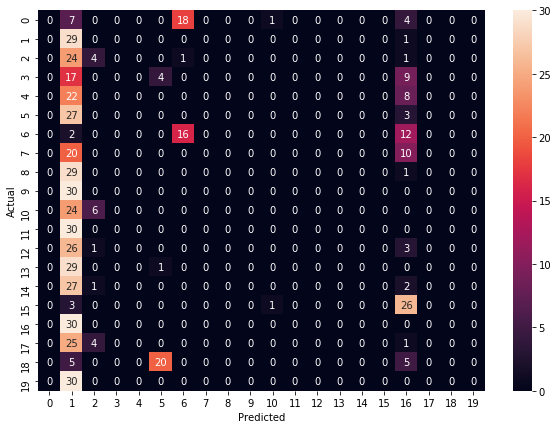

In [122]:
net_rep2.eval()
count = 0
testing_true = torch.zeros([len(train_loader.dataset),2])
for i, (tact_icub, tact_bio,  target, label) in enumerate(train_loader, 0):
    testing_true[count:count+label.shape[0],0] = label
    
    # Forward pass of the network.
    tact_bio = tact_bio.to(device)
    tact_bio = tact_bio[...,::2]
    output, _, rep_out_bio, _ = net_rep.forward(tact_bio)
#     output = net_rep.classifier(rep_out_bio) # classifier
    predicted_label = snn.predict.getClass(output)
    
    testing_true[count:count+label.shape[0],1] = predicted_label
    print(label, predicted_label)
    count += label.shape[0]
cm = confusion_matrix(testing_true[:,0].numpy(), testing_true[:,1].numpy())
plt.figure(figsize = (10,7))
plt.tight_layout(True)
sn.heatmap(cm, annot=True)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [83]:
# save stats
import pickle
all_stats = [
    train_total_losses,
    train_class_losses,
    train_regres_losses,
    val_total_losses,
    val_class_losses,
    val_regres_losses,
    train_accs,
    val_accs
]

pickle.dump(all_stats, open(logDir + model_name + '_stats.pkl', 'wb'))

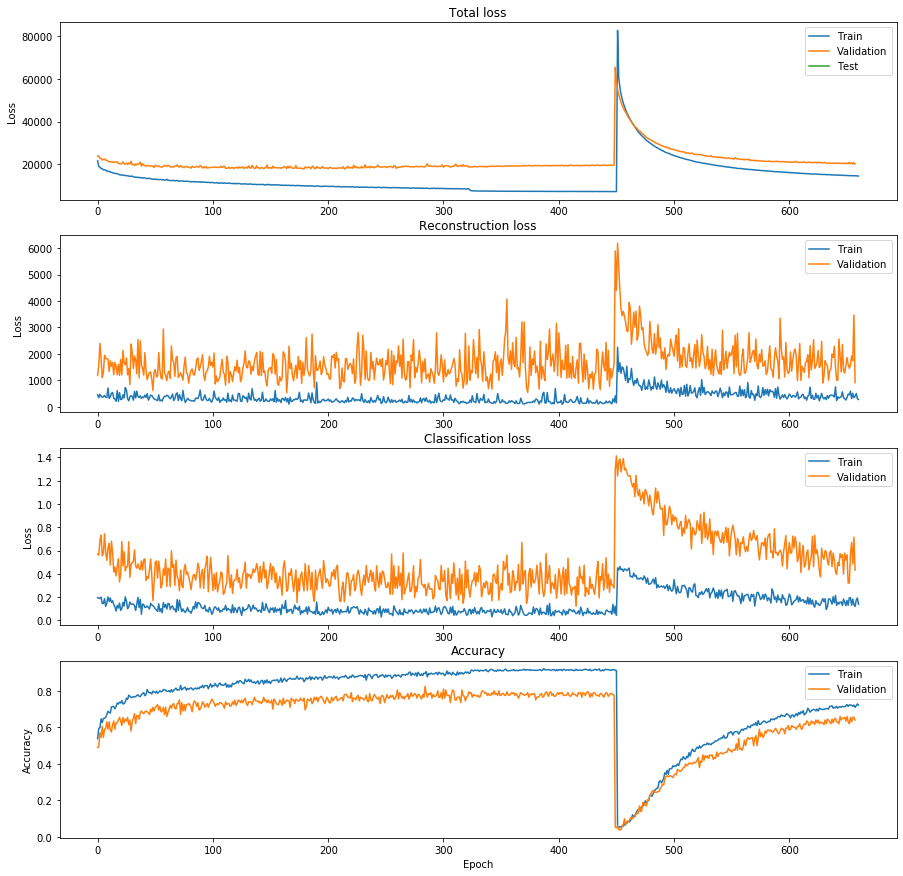

In [84]:
fig, ax = plt.subplots(4, figsize=(15,15))

ax[0].set_title('Total loss')
ax[0].plot(train_total_losses)
ax[0].plot(val_total_losses)
ax[0].plot(test_total_losses)
ax[0].set_ylabel('Loss')
ax[0].legend(['Train', 'Validation', 'Test'])

ax[1].set_title('Reconstruction loss')
ax[1].plot(train_regres_losses)
ax[1].plot(val_regres_losses)
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'])

ax[2].set_title('Classification loss')
ax[2].plot(train_class_losses)
ax[2].plot(val_class_losses)
ax[2].set_ylabel('Loss')
ax[2].legend(['Train', 'Validation'])

ax[3].set_title('Accuracy')
ax[3].plot(train_accs)
ax[3].plot(val_accs)
ax[3].set_xlabel('Epoch')
ax[3].set_ylabel('Accuracy')
ax[3].legend(['Train', 'Validation'])

plt.show()

In [85]:
# testing set check
net_trained = TransferLearn(params, 60, 50, 50, 50, 20).to(device)
net_trained.load_state_dict(torch.load(save_dir))
net_trained.eval()

TransferLearn(
  (slayer): spikeLayer()
  (fc1): _denseLayer(60, 50, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
  (fc2): _denseLayer(50, 50, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
  (fc3): _denseLayer(50, 50, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
)

In [89]:
correct = 0
loss_test = 0
net.eval()
with torch.no_grad():
    for i, (tact_icub, tact_bio, target, label) in enumerate(test_loader):

        tact_icub = tact_icub.to(device)
        rep_out_icub = net.forward(tact_icub)
        output = net_rep.classifier(rep_out_icub) # classifier

        correct += torch.sum(snn.predict.getClass(output) == label).data.item()

In [90]:
print(correct/len(test_loader.dataset))

0.08


### visualize latent representation

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
def get_metrics(lloader, _net):
    # Draw representations
    _net.eval()
    big_list = []
    label_list=[]
    with torch.no_grad():
        for i, (_, tact, target, label) in enumerate(lloader):

            tact = tact.to(device)
            target = target.to(device)
            tact = net.get_spike(tact)
            _, _, rep, _ = _net.forward(tact)
            big_list.append(rep)
            label_list.append(label)

    test_representation = torch.cat(big_list,0)
    label_all = torch.cat(label_list, 0)
    label_all = label_all.cpu().numpy()
    dist_mat = torch.zeros([len(lloader.dataset),len(lloader.dataset)])
    for i in range(len(lloader.dataset)):
        for j in range(len(lloader.dataset)):
            if i == j:
                dist_mat[i, j] = 0.0
            else:
                dist_mat[i,j] = error2.spikeTime(test_representation[i], test_representation[j])

    dist_mat = dist_mat.detach().cpu().numpy()
    
    return dist_mat, label_all

In [ ]:
# test
dist_mat, label_all = get_metrics(test_loader, net)

In [ ]:
tsne_model = TSNE(n_components=2,perplexity=30, metric='precomputed')

In [ ]:
X_embedded = tsne_model.fit_transform(dist_mat)

In [ ]:
fig, ax = plt.subplots()
ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c=label_all, cmap=plt.cm.Spectral)
plt.show()

In [ ]:
# train
dist_mat, label_all = get_metrics(train_loader, net)

In [ ]:
X_embedded = tsne_model.fit_transform(dist_mat)

In [ ]:
fig, ax = plt.subplots()
ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c=label_all, cmap=plt.cm.Spectral)
plt.show()